In [339]:
import pandas as pd
import numpy as np
import os
import glob
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn
import sklearn
from shapely.geometry import Point, Polygon, box
import scipy

seaborn.set()
# numpy pandas shapely geopandas rasterio
cwd_path = os.getcwd()
usa_quake_path = cwd_path + "\\earthquake_contiguous_usa_12batch\\"
eu_quake_path = cwd_path + "\\Earthquake_2016_2018_all_eu\\"

In [340]:
# Used to enumerate the files in each directory.
# Useful for finding a sepcific file's index for the us_df[] and eu_df[] arrays/list

for x, us in enumerate(glob.glob(usa_quake_path+"*.csv")):
    print("%2i %s" % (x,os.path.basename(us)))
print()
for x, eu in enumerate(glob.glob(eu_quake_path+"*.csv")):
    print("%2i %s" % (x,os.path.basename(eu)))

 0 Earthquake_2020_09_2020_10_filtered.csv
 1 Earthquake_2020_11_2020_12_filtered.csv
 2 Earthquake_2021_01_2021_02_filtered.csv
 3 Earthquake_2021_03_2021_04_filtered.csv
 4 Earthquake_2021_05_2021_06_filtered.csv
 5 Earthquake_2021_07_2021_08_filtered.csv
 6 Earthquake_2021_09_2021_10_filtered.csv
 7 Earthquake_2021_11_2021_12_filtered.csv
 8 Earthquake_2022_01_2022_02_filtered.csv
 9 Earthquake_2022_03_2022_04_filtered.csv
10 Earthquake_2022_05_2022_06_filtered.csv
11 Earthquake_2022_07_2022_08_filtered.csv

 0 Earthquake_2016_10_filtered_eu.csv
 1 Earthquake_2016_11_filtered_eu.csv
 2 Earthquake_2016_12_filtered_eu.csv
 3 Earthquake_2016_1_filtered_eu.csv
 4 Earthquake_2016_2_filtered_eu.csv
 5 Earthquake_2016_3_filtered_eu.csv
 6 Earthquake_2016_4_filtered_eu.csv
 7 Earthquake_2016_5_filtered_eu.csv
 8 Earthquake_2016_6_filtered_eu.csv
 9 Earthquake_2016_7_filtered_eu.csv
10 Earthquake_2016_8_filtered_eu.csv
11 Earthquake_2016_9_filtered_eu.csv
12 Earthquake_2017_10_filtered_eu.cs

In [341]:
# CSVs are appended to an array/list as DataFames.
# Done for both US and EU data
us_df = []
eu_df = []
for us in glob.glob(usa_quake_path+"*.csv"):
    us_df.append(pd.read_csv(us))


for eu in glob.glob(eu_quake_path+"*.csv"):
    eu_df.append(pd.read_csv(eu))


In [342]:
# Batch allocation
us_batch = []
for y in range(10):
    batch = pd.concat((us_df[y+0], us_df[y+1], us_df[y+2]),ignore_index=True)
    us_batch.append(batch)
print(len(us_batch))
print(us_batch)

10
[                          time   latitude   longitude      depth   mag
0     2020-09-01T00:30:52.227Z  38.176500 -117.801900   6.700000  3.50
1     2020-09-01T00:36:59.811Z  38.003900 -118.235800   6.600000  3.40
2     2020-09-01T01:39:34.960Z  36.394333 -120.437000   9.190000  2.87
3     2020-09-01T02:25:49.130Z  42.370000 -118.444000   8.450000  3.52
4     2020-09-01T05:51:36.757Z  38.179800 -117.863400   9.200000  3.30
...                        ...        ...         ...        ...   ...
1649  2021-02-28T20:12:49.320Z  34.326167 -116.923500   5.510000  2.94
1650  2021-02-28T20:56:22.890Z  32.068176 -102.241449   8.779256  3.20
1651  2021-02-28T21:38:38.590Z  36.363167  -98.155333   7.220000  3.68
1652  2021-02-28T22:00:42.397Z  31.688448 -104.300805   6.568604  3.20
1653  2021-02-28T23:32:57.854Z  38.169400 -117.898600  11.600000  2.80

[1654 rows x 5 columns],                           time   latitude   longitude      depth   mag
0     2020-11-01T00:47:37.474Z  31.606700 -104.

In [343]:
# Geo batch allocation
geo_us_batch = []
for y in range(10):
    geo_us_batch.append(gpd.GeoDataFrame(us_batch[y]))

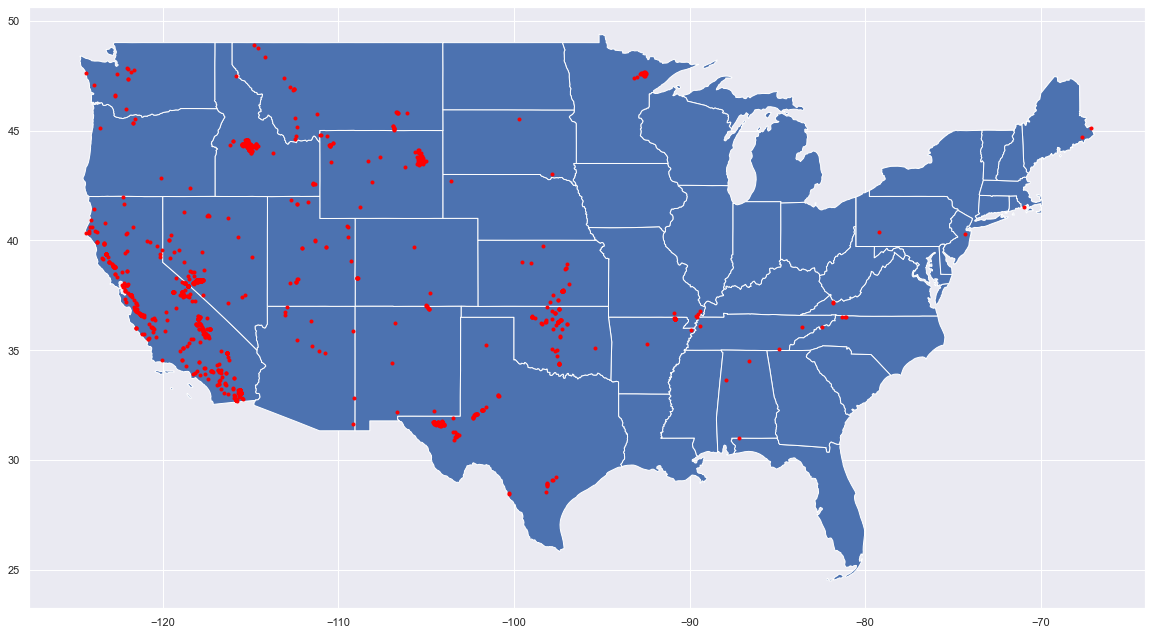

In [344]:
plt.rcParams["figure.figsize"] = [20, 20]
states = gpd.read_file('data/usa-states-census-2014.shp')
states.plot()
plt.scatter(geo_us_batch[0].longitude, geo_us_batch[0].latitude,c="red",marker='.')

In [345]:
# Geo pandas stuff only using the first batch
d = us_batch[0][:]
geo = gpd.GeoDataFrame(d.drop(['longitude', 'latitude'], axis = 1), crs='epsg:4326',geometry=[Point(xy) for xy in zip(d.longitude, d.latitude)])

#fig, ax = plt.subplots(figsize=(20,20))
#ax.set_aspect('equal')
#geo_states = gpd.read_file('data/usa-states-census-2014.shp')
#geo_states.plot(ax=ax)
#geo.plot(ax=ax, alpha=0.5, cmap='viridis', linewidth=0.8,marker='o')
#geo

In [346]:
# how many cells across and down
xmin, ymin, xmax, ymax= geo.total_bounds
n_cells=45
cell_size = (xmax-xmin)/n_cells

# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],crs='epsg:4326')

In [348]:
# shae code
# WARNING takes a while to run
min_max_table=[] # is an array of cells bounds for each cell
geo_table=[]     # is an array of long and lat from batch(es)
counter=[]       # is an array that holds occurences of quakes per cell

# gives the min and max longs and lats for given cells (aka the bounds of the cell)
for i in range(len(cell)):
    xmin, ymin, xmax, ymax= cell.loc[i].geometry.bounds
    min_max_table.append([xmin,ymin,xmax,ymax])
# appends the points from the geodataframe 'Geometry.Point'
for j in range(len(geo)):
    geo_table.append([geo.geometry.x[j], geo.geometry.y[j]])

In [334]:
# first for goes through each cell then second for counts occurences in each cell
for i in range(len(cell)):
    counter.append(0)
    for j in range(len(geo)):
        if ((geo_table[j][0] < min_max_table[i][2]) & (geo_table[j][0] > min_max_table[i][0]) & (geo_table[j][1] < min_max_table[i][3]) & (geo_table[j][1] > min_max_table[i][1])):
            counter[i] +=1

<AxesSubplot: >

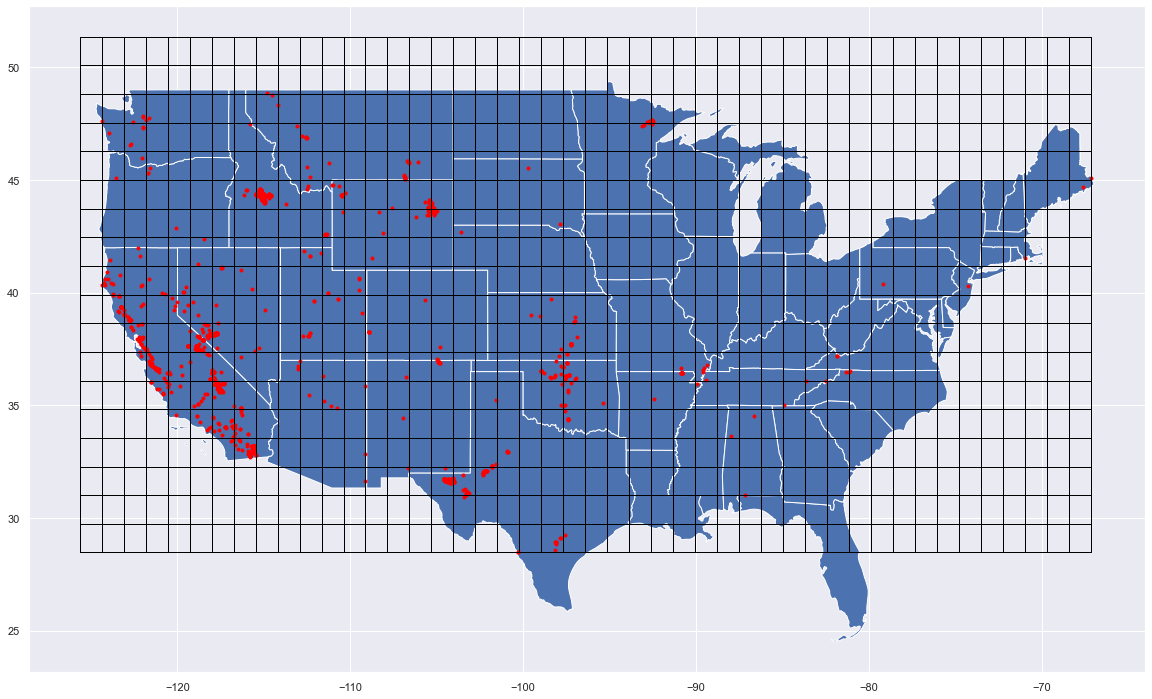

In [347]:
plt.rcParams["figure.figsize"] = [20, 20]
stat_plot=states.plot()
plt.scatter(geo_us_batch[0].longitude, geo_us_batch[0].latitude,c="red",marker='.')
cell.plot(ax=stat_plot, facecolor="none", edgecolor='black')